In [33]:
import sys
sys.path.append('../..')

import os
import json
import qiskit
import pandas as pd
import numpy as np
from typing import List
from natsort import natsorted
from phoenix.models import HamiltonianModel
from phoenix.utils import arch
from qiskit.transpiler import CouplingMap

import matplotlib.pyplot as plt

In [9]:
Manhattan = CouplingMap(arch.read_device_topology('../manhattan.graphml').to_directed().edge_list())
json_dpath = '../../benchmarks/qaoa_json'

**2QAN results on Manhattan:**

```
../../benchmarks/qaoa_text/qaoa_rand_16.txt CNOT gate count by 2QAN: 190
../../benchmarks/qaoa_text/qaoa_rand_20.txt CNOT gate count by 2QAN: 229
../../benchmarks/qaoa_text/qaoa_rand_24.txt CNOT gate count by 2QAN: 294
../../benchmarks/qaoa_text/qaoa_reg3_16.txt CNOT gate count by 2QAN: 178
../../benchmarks/qaoa_text/qaoa_reg3_20.txt CNOT gate count by 2QAN: 191
../../benchmarks/qaoa_text/qaoa_reg3_24.txt CNOT gate count by 2QAN: 250
```


In [ ]:

fnames = ['qaoa_rand_16', 'qaoa_rand_20', 'qaoa_rand_24', 'qaoa_reg3_16', 'qaoa_reg3_20', 'qaoa_reg3_24']
num_2q_2qan = []
depth_2q_2qan = []
for fname in fnames:
    fname = os.path.join('./2qan', fname + '.qasm')
    qc = qiskit.QuantumCircuit.from_qasm_file(fname)
    num_2q_2qan.append(qc.num_nonlocal_gates())
    depth_2q_2qan.append(qc.depth(lambda instr: instr.operation.num_qubits > 1))


In [10]:
num_2q_2qan

[170, 219, 274, 148, 186, 223]

In [11]:
depth_2q_2qan

[85, 89, 100, 61, 48, 64]

In [ ]:
def qiskit_O3_all2all(circ: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    from itertools import combinations
    for q0, q1 in combinations(range(circ.num_qubits), 2):
        circ.cx(q0, q1)
        circ.cx(q0, q1)
    circ = qiskit.transpile(circ, optimization_level=3, basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ


def phoenix_pass(paulis: List[str], coeffs: List[float], coupling_map: CouplingMap) -> qiskit.QuantumCircuit:
    """Phoenix's high-level optimization"""
    ham = HamiltonianModel(paulis, coeffs)
    # circ = ham.reconfigure_and_generate_circuit() # this is the old version
    circ = ham.phoenix_circuit()


    circ = qiskit_O3_all2all(circ.to_qiskit())  # since input is logical circuit, we can first ally a all2all Qiskit O3
    circ = qiskit.transpile(circ, optimization_level=3,
                            basis_gates=['u1', 'u2', 'u3', 'cx'],
                            coupling_map=coupling_map, layout_method='sabre')
    return circ

In [17]:
num_2q_phoenix = []
depth_2q_phoenix = []
for fname in fnames:
    fname = os.path.join(json_dpath, fname + '.json')
    with open(fname, 'r') as f:
        data = json.load(f)
    
    circ = phoenix_pass(data['paulis'], data['coeffs'], Manhattan)
    num_2q_phoenix.append(circ.num_nonlocal_gates())
    depth_2q_phoenix.append(circ.depth(lambda instr: instr.operation.num_qubits > 1))



In [26]:
depth_2q_phoenix

[51, 62, 76, 31, 32, 40]

In [27]:
num_2q_phoenix

[145, 195, 249, 94, 132, 160]

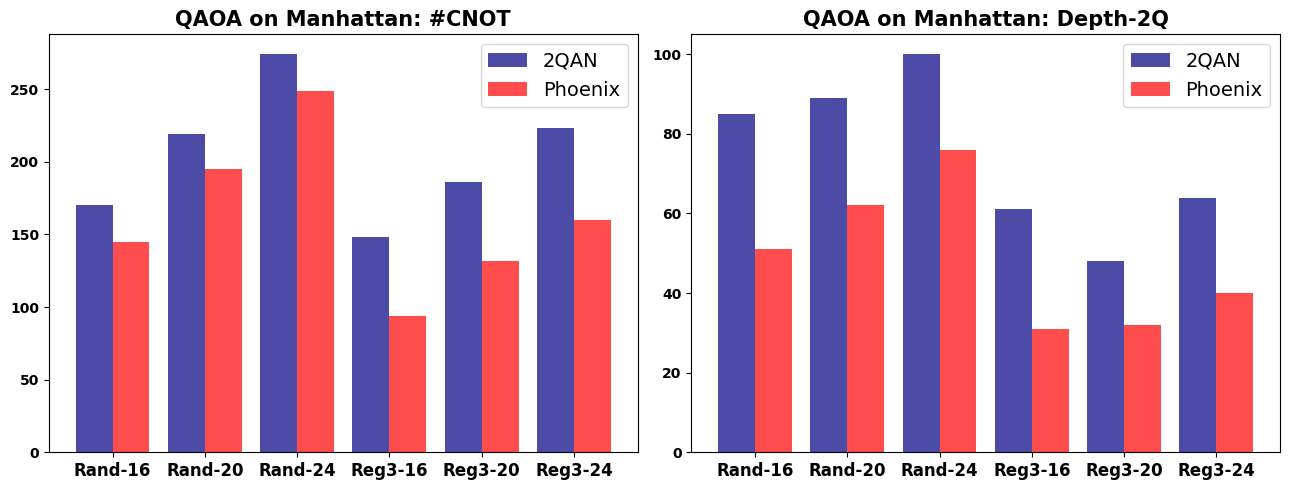

In [ ]:
plt.figure(figsize=(13, 5))


plt.subplot(1, 2, 1)
width = 0.4
xticks = [fname.replace('qaoa_', '').replace('_', '-').capitalize() for fname in fnames]
plt.bar(np.arange(len(xticks)) - 0.5 * width, num_2q_2qan, width=width, label='2QAN', color='navy', alpha=0.7)
plt.bar(np.arange(len(xticks)) + 0.5 * width, num_2q_phoenix, width=width, label='Phoenix', color='red', alpha=0.7)
plt.xticks(range(len(xticks)), xticks, fontsize=12, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.yticks(fontweight='bold')
plt.title('QAOA on Manhattan: #CNOT', fontsize=15, fontweight='bold')

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(xticks)) - 0.5 * width, depth_2q_2qan, width=width, label='2QAN', color='navy', alpha=0.7)
plt.bar(np.arange(len(xticks)) + 0.5 * width, depth_2q_phoenix, width=width, label='Phoenix', color='red', alpha=0.7)
plt.xticks(range(len(xticks)), xticks, fontsize=12, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.yticks(fontweight='bold')
plt.title('QAOA on Manhattan: Depth-2Q', fontsize=15, fontweight='bold')


plt.tight_layout()
# plt.savefig('../figures/qaoa.pdf')


In [93]:
for fname in fnames:
    json_fname = os.path.join(json_dpath, fname + '.json')
    with open(json_fname, 'r') as f:
        data = json.load(f)

    ham = HamiltonianModel(data['paulis'], data['coeffs'])
    circ = ham.generate_circuit()

    print(fname, data['num_qubits'], len(data['paulis']), circ.num_nonlocal_gates, circ.depth_nonlocal)

qaoa_rand_16 16 32 64 36
qaoa_rand_20 20 40 80 32
qaoa_rand_24 24 48 96 48
qaoa_reg3_16 16 24 48 18
qaoa_reg3_20 20 30 60 22
qaoa_reg3_24 24 36 72 20
